In [54]:
import requests
import json
import os
from WSMethods import *
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
import vxi11
import math

In [55]:
#光スペアナ接続
instr =  vxi11.Instrument("169.254.6.1")
print(instr.ask("*IDN?"))

#Waveshaper接続
# Define device IP
ip = '169.254.6.8'
# Get device info 
result = requests.get('http://' + ip + '/waveshaper/devinfo').json()

#print(result)
# Set frequency variables from device info
s = result['startfreq']
e = result['stopfreq']

YOKOGAWA,AQ6370D,91X206982,02.07


In [56]:
def getOSA(trace_name):
    c = 299792458

    #光スペアナのx軸（波長）取得
    wavelength = instr.ask(':TRACe:X? '+trace_name)
    wavelength = wavelength.split(',')
    wavelength = [float(ii) for ii in wavelength]
    #print(wavelength[0])
    wavelength = np.array(wavelength)#m

    freq = [c/ii/10**12 for ii in wavelength]#THz
    #print(freq[0])
    #print(freq[-1])

    #光スペアナのy軸（dBm/nm）取得
    nrf = instr.ask(':CALCULATE:MATH:TRF:PNBW:BAND?')#正規化帯域幅
    #print(nrf)#0.1という数値が出てくるものの何のため？

    data = instr.ask(':TRACe:Y:PDENsity? '+trace_name+',1nm')
    data = data.split(',')
    data = [float(ii) for ii in data]
    data = np.array(data)

    optFreq = freq
    optSpectrum = data

    optFreq = optFreq[::-1]
    optSpectrum = optSpectrum[::-1]

    optFreq = np.hstack((s-0.05,optFreq))
    optFreq = np.hstack((optFreq,e+0.05))
    optSpectrum = np.hstack((optSpectrum[0],optSpectrum))
    optSpectrum = np.hstack((optSpectrum,optSpectrum[-1]))
    
    return optFreq,optSpectrum

0.0004989294222355056


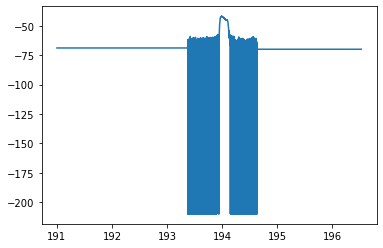

In [57]:
optFreq,optSpectrum = getOSA('TRA')
plt.plot(optFreq, optSpectrum)
print(optFreq[2] - optFreq[1])

0.0004989294222355056


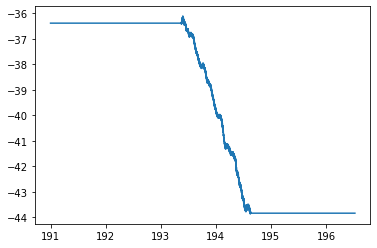

In [58]:
optFreq_main,optSpectrum_main = getOSA('TRE')
plt.plot(optFreq_main, optSpectrum_main)
print(optFreq_main[2] - optFreq_main[1])

In [98]:
targetAttn = optSpectrum_main-optSpectrum


In [99]:
print(s)
print(e)
wsFreq = np.arange(s, e + 0.001, 0.001)
print(wsFreq)

191.05
196.475
[191.05  191.051 191.052 ... 196.473 196.474 196.475]


In [100]:
#f = interp1d(optFreq, optSpectrum, kind='linear')
f = interp1d(optFreq, targetAttn, kind='linear')

optSpectrumInterp = f(wsFreq)
maxPower = max(optSpectrumInterp)
normPower = -4
calb = 0 # yokuwakaranai


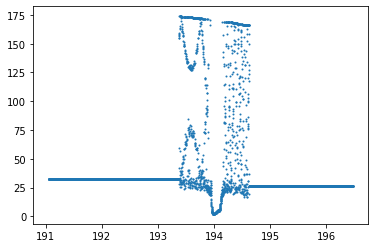

In [101]:
#plt.scatter(wsFreq, ((optSpectrumInterp - maxPower) - normPower)  - calb,s=1)
plt.scatter(wsFreq, optSpectrumInterp,s=1)

In [102]:
#wsAttn = (optSpectrumInterp - maxPower) - normPower - calb
#test = [min(ii,-60) for ii in optSpectrumInterp]
wsAttn = optSpectrumInterp
wsPhase = np.zeros(wsFreq.shape)
wsPort = np.ones(wsFreq.shape)
# Upload profile using created data
r = uploadProfile(ip, wsFreq, wsAttn, wsPhase, wsPort)

In [87]:
#np.savetxt("test.wsp", )
instr.close()